In [1]:
%load_ext autoreload
%autoreload 2   

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

torch.__version__

'2.8.0'

In [5]:
class GCNLayer(nn.Module):
    """Single Graph Convolutional Layer"""

    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.weight = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = nn.Parameter(torch.randn(out_features))

    def forward(self, x, adj):
        """
        Forward pass of GCN layer
        x: Node features [num_nodes, in_features]
        adj: Normalized adjacency matrix [num_nodes, num_nodes]
        """
        # Aggregate neighbor embeddings: A * X
        support = torch.mm(adj, x)
        # Apply linear transformation: A * X * W + b
        output = torch.mm(support, self.weight) + self.bias
        return output


In [6]:
class GCN(nn.Module):
    """Graph Convolutional Network for node embeddings"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(GCN, self).__init__()
        self.num_layers = num_layers

        # Build layers
        self.layers = nn.ModuleList()

        # First layer
        self.layers.append(GCNLayer(input_dim, hidden_dim))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.layers.append(GCNLayer(hidden_dim, hidden_dim))

        # Output layer
        self.layers.append(GCNLayer(hidden_dim, output_dim))

    def forward(self, x, adj):
        """
        Forward pass through all GCN layers
        """
        h = x

        # Apply all layers except the last one with ReLU
        for i in range(len(self.layers) - 1):
            h = F.relu(self.layers[i](h, adj))

        # Apply final layer without activation
        h = self.layers[-1](h, adj)

        return h


Training GCN on Zachary's Karate Club dataset...
Epoch 000, Loss: inf
Epoch 050, Loss: nan
Epoch 100, Loss: nan
Epoch 150, Loss: nan

Embedding Statistics:
Embedding dimension: 8
Number of nodes: 34
Embedding norm (mean): nan


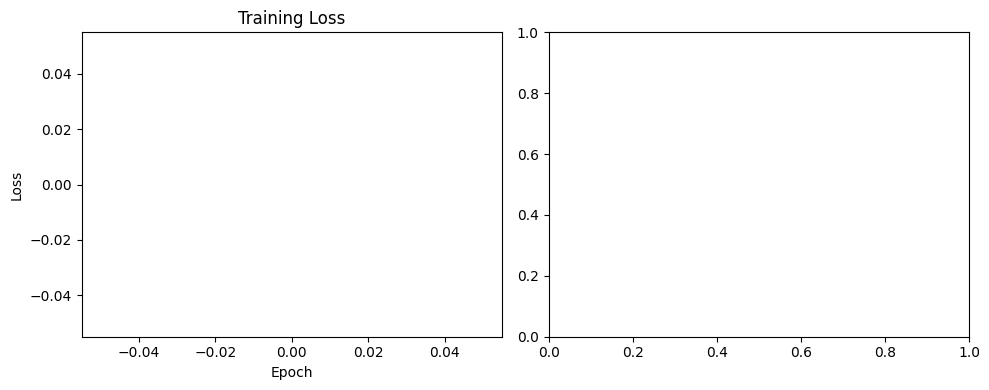

ValueError: Input X contains NaN.
TSNE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [7]:
def normalize_adjacency(adj):
    """
    Normalize adjacency matrix: D^(-1/2) * A * D^(-1/2)
    where D is the degree matrix
    """
    # Add self-loops
    adj = adj + torch.eye(adj.size(0))

    # Compute degree matrix
    degree = torch.sum(adj, dim=1)

    # Compute D^(-1/2)
    degree_inv_sqrt = torch.pow(degree, -0.5)
    degree_inv_sqrt[torch.isinf(degree_inv_sqrt)] = 0.0

    # Create diagonal matrix
    degree_matrix_inv_sqrt = torch.diag(degree_inv_sqrt)

    # Normalize: D^(-1/2) * A * D^(-1/2)
    normalized_adj = torch.mm(
        torch.mm(degree_matrix_inv_sqrt, adj), degree_matrix_inv_sqrt
    )

    return normalized_adj


def load_karate_club():
    """Load Zachary's Karate Club dataset"""
    G = nx.karate_club_graph()

    # Create adjacency matrix
    adj = torch.tensor(nx.adjacency_matrix(G).todense(), dtype=torch.float32)

    # Create node features (using node degrees as features)
    degrees = torch.tensor(
        [G.degree(i) for i in G.nodes()], dtype=torch.float32
    ).unsqueeze(1)

    # Normalize features
    features = degrees / degrees.max()

    # Get ground truth labels (clubs)
    labels = torch.tensor(
        [G.nodes[i]["club"] == "Mr. Hi" for i in G.nodes()], dtype=torch.long
    )

    return features, adj, labels, G


def unsupervised_loss(embeddings, adj, labels=None):
    """
    Unsupervised loss based on node similarity
    Similar nodes (connected by edges) should have similar embeddings
    """
    # Get all edge indices
    edge_indices = torch.nonzero(adj, as_tuple=False)

    # Compute positive samples (actual edges)
    pos_loss = 0
    num_edges = edge_indices.size(0)

    for i in range(num_edges):
        u, v = edge_indices[i]
        if u != v:  # Skip self-loops
            # Compute similarity (dot product)
            similarity = torch.dot(embeddings[u], embeddings[v])
            # Sigmoid and negative log likelihood
            pos_loss += -torch.log(torch.sigmoid(similarity))

    # Compute negative samples (random non-edges)
    num_nodes = adj.size(0)
    neg_loss = 0
    num_neg_samples = num_edges

    for _ in range(num_neg_samples):
        # Sample random pair
        u = torch.randint(0, num_nodes, (1,)).item()
        v = torch.randint(0, num_nodes, (1,)).item()

        # Check if it's not an edge and not the same node
        if adj[u, v] == 0 and u != v:
            similarity = torch.dot(embeddings[u], embeddings[v])
            neg_loss += -torch.log(1 - torch.sigmoid(similarity))

    total_loss = (pos_loss + neg_loss) / (num_edges + num_neg_samples)
    return total_loss


def train_gcn():
    """Train the GCN model"""
    # Load data
    features, adj, labels, G = load_karate_club()

    # Normalize adjacency matrix
    adj_normalized = normalize_adjacency(adj)

    # Model parameters
    input_dim = features.size(1)
    hidden_dim = 16
    output_dim = 8

    # Initialize model
    model = GCN(input_dim, hidden_dim, output_dim, num_layers=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    # Training loop
    model.train()
    losses = []

    for epoch in range(200):
        optimizer.zero_grad()

        # Forward pass
        embeddings = model(features, adj_normalized)

        # Compute loss
        loss = unsupervised_loss(embeddings, adj)

        # Backward pass
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if epoch % 50 == 0:
            print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}")

    return model, features, adj_normalized, labels, G, losses


def visualize_embeddings(model, features, adj_normalized, labels, G):
    """Visualize the learned embeddings"""
    model.eval()
    with torch.no_grad():
        embeddings = model(features, adj_normalized).numpy()

    # Use t-SNE for 2D visualization
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot embeddings
    plt.figure(figsize=(12, 5))

    # Plot 1: Embeddings colored by true labels
    plt.subplot(1, 2, 1)
    colors = ["red" if label == 1 else "blue" for label in labels.numpy()]
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, s=50)
    plt.title("Node Embeddings (Colored by True Labels)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")

    # Add node labels
    for i, (x, y) in enumerate(embeddings_2d):
        plt.annotate(
            str(i), (x, y), xytext=(5, 5), textcoords="offset points", fontsize=8
        )

    # Plot 2: Original graph structure
    plt.subplot(1, 2, 2)
    pos = nx.spring_layout(G, seed=42)
    node_colors = [
        "red" if G.nodes[i]["club"] == "Mr. Hi" else "blue" for i in G.nodes()
    ]
    nx.draw(
        G, pos, node_color=node_colors, with_labels=True, node_size=300, font_size=8
    )
    plt.title("Original Karate Club Graph")

    plt.tight_layout()
    plt.show()


def main():
    """Main training and evaluation"""
    print("Training GCN on Zachary's Karate Club dataset...")

    # Train model
    model, features, adj_normalized, labels, G, losses = train_gcn()

    # Plot training loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # Visualize embeddings
    plt.subplot(1, 2, 2)
    model.eval()
    with torch.no_grad():
        embeddings = model(features, adj_normalized)

    # Print embedding statistics
    print(f"\nEmbedding Statistics:")
    print(f"Embedding dimension: {embeddings.size(1)}")
    print(f"Number of nodes: {embeddings.size(0)}")
    print(f"Embedding norm (mean): {torch.norm(embeddings, dim=1).mean():.4f}")

    plt.tight_layout()
    plt.show()

    # Visualize embeddings in detail
    visualize_embeddings(model, features, adj_normalized, labels, G)

    return model, embeddings


if __name__ == "__main__":
    model, embeddings = main()